### **EVALUTING THE PERFORMANCE OF A REGRESSION MODEL**

This code is to evaluate a regression model that predicts blood mercury concentration using a set of metabolic, lipid, and heavy metal biomarkers from the National Health and Nutrition Examination Survey (NHANES) 2017–2018

In [19]:
#Import the basic necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Data Preprocessing**

In [3]:
#Load the dataset
df = pd.read_csv('/content/drive/MyDrive/laboratory.csv')

#Select and rename variables for clarity
lab = df[['LBXGLU',
                 'LBDINSI',
                 'LBDHDDSI',
                 'LBDTCSI',
                 'LBDBPBSI',
                 'LBDTHGSI',
                 'LBDBMNSI',
                 'LBXSASSI',
                 'LBXSATSI']]

lab = lab.rename(columns={
    'LBXGLU': 'Fasting Glucose',
    'LBDINSI': 'Insulin',
    'LBDHDDSI': 'HDL Cholesterol',
    'LBDTCSI': 'Total Cholesterol',
    'LBDBPBSI': 'Blood Lead',
    'LBDTHGSI': 'Blood Mercury',
    'LBDBMNSI': 'Blood Manganese',
    'LBXSASSI': 'AST',
    'LBXSATSI': 'ALT'
})

Removed missing values: Ensured the dataset was clean and consistent for modelling

In [6]:
#Handle missing values
lab.dropna(axis=0, how='any', inplace=True)
lab.head(5)

,Fasting Glucose,Insulin,HDL Cholesterol,Total Cholesterol,Blood Lead,Blood Mercury,Blood Manganese,AST,ALT
5,122.0,58.32,2.28,5.40,0.07,76.00,274.67,21.0,19.0
7,107.0,31.68,1.86,6.15,0.10,1.00,119.22,23.0,20.0
13,91.0,23.64,1.37,5.51,0.09,1.80,162.91,17.0,13.0
14,89.0,29.34,1.63,3.93,0.03,11.38,218.42,17.0,13.0
15,86.0,65.64,1.19,2.51,0.01,1.00,138.88,14.0,17.0


Log-transformed mercury: Reduced right-skew and stabilized variance for better model performance.

In [9]:
lab['Blood Mercury log'] = np.log1p(lab['Blood Mercury'])
lab.head(5)

,Fasting Glucose,Insulin,HDL Cholesterol,Total Cholesterol,Blood Lead,Blood Mercury,Blood Manganese,AST,ALT,Blood Mercury log
5,122.0,58.32,2.28,5.40,0.07,76.00,274.67,21.0,19.0,4.343805
7,107.0,31.68,1.86,6.15,0.10,1.00,119.22,23.0,20.0,0.693147
13,91.0,23.64,1.37,5.51,0.09,1.80,162.91,17.0,13.0,1.029619
14,89.0,29.34,1.63,3.93,0.03,11.38,218.42,17.0,13.0,2.516082
15,86.0,65.64,1.19,2.51,0.01,1.00,138.88,14.0,17.0,0.693147


## Visualising the Data
Using scatter plot to view the relationship between mercury and the other variables

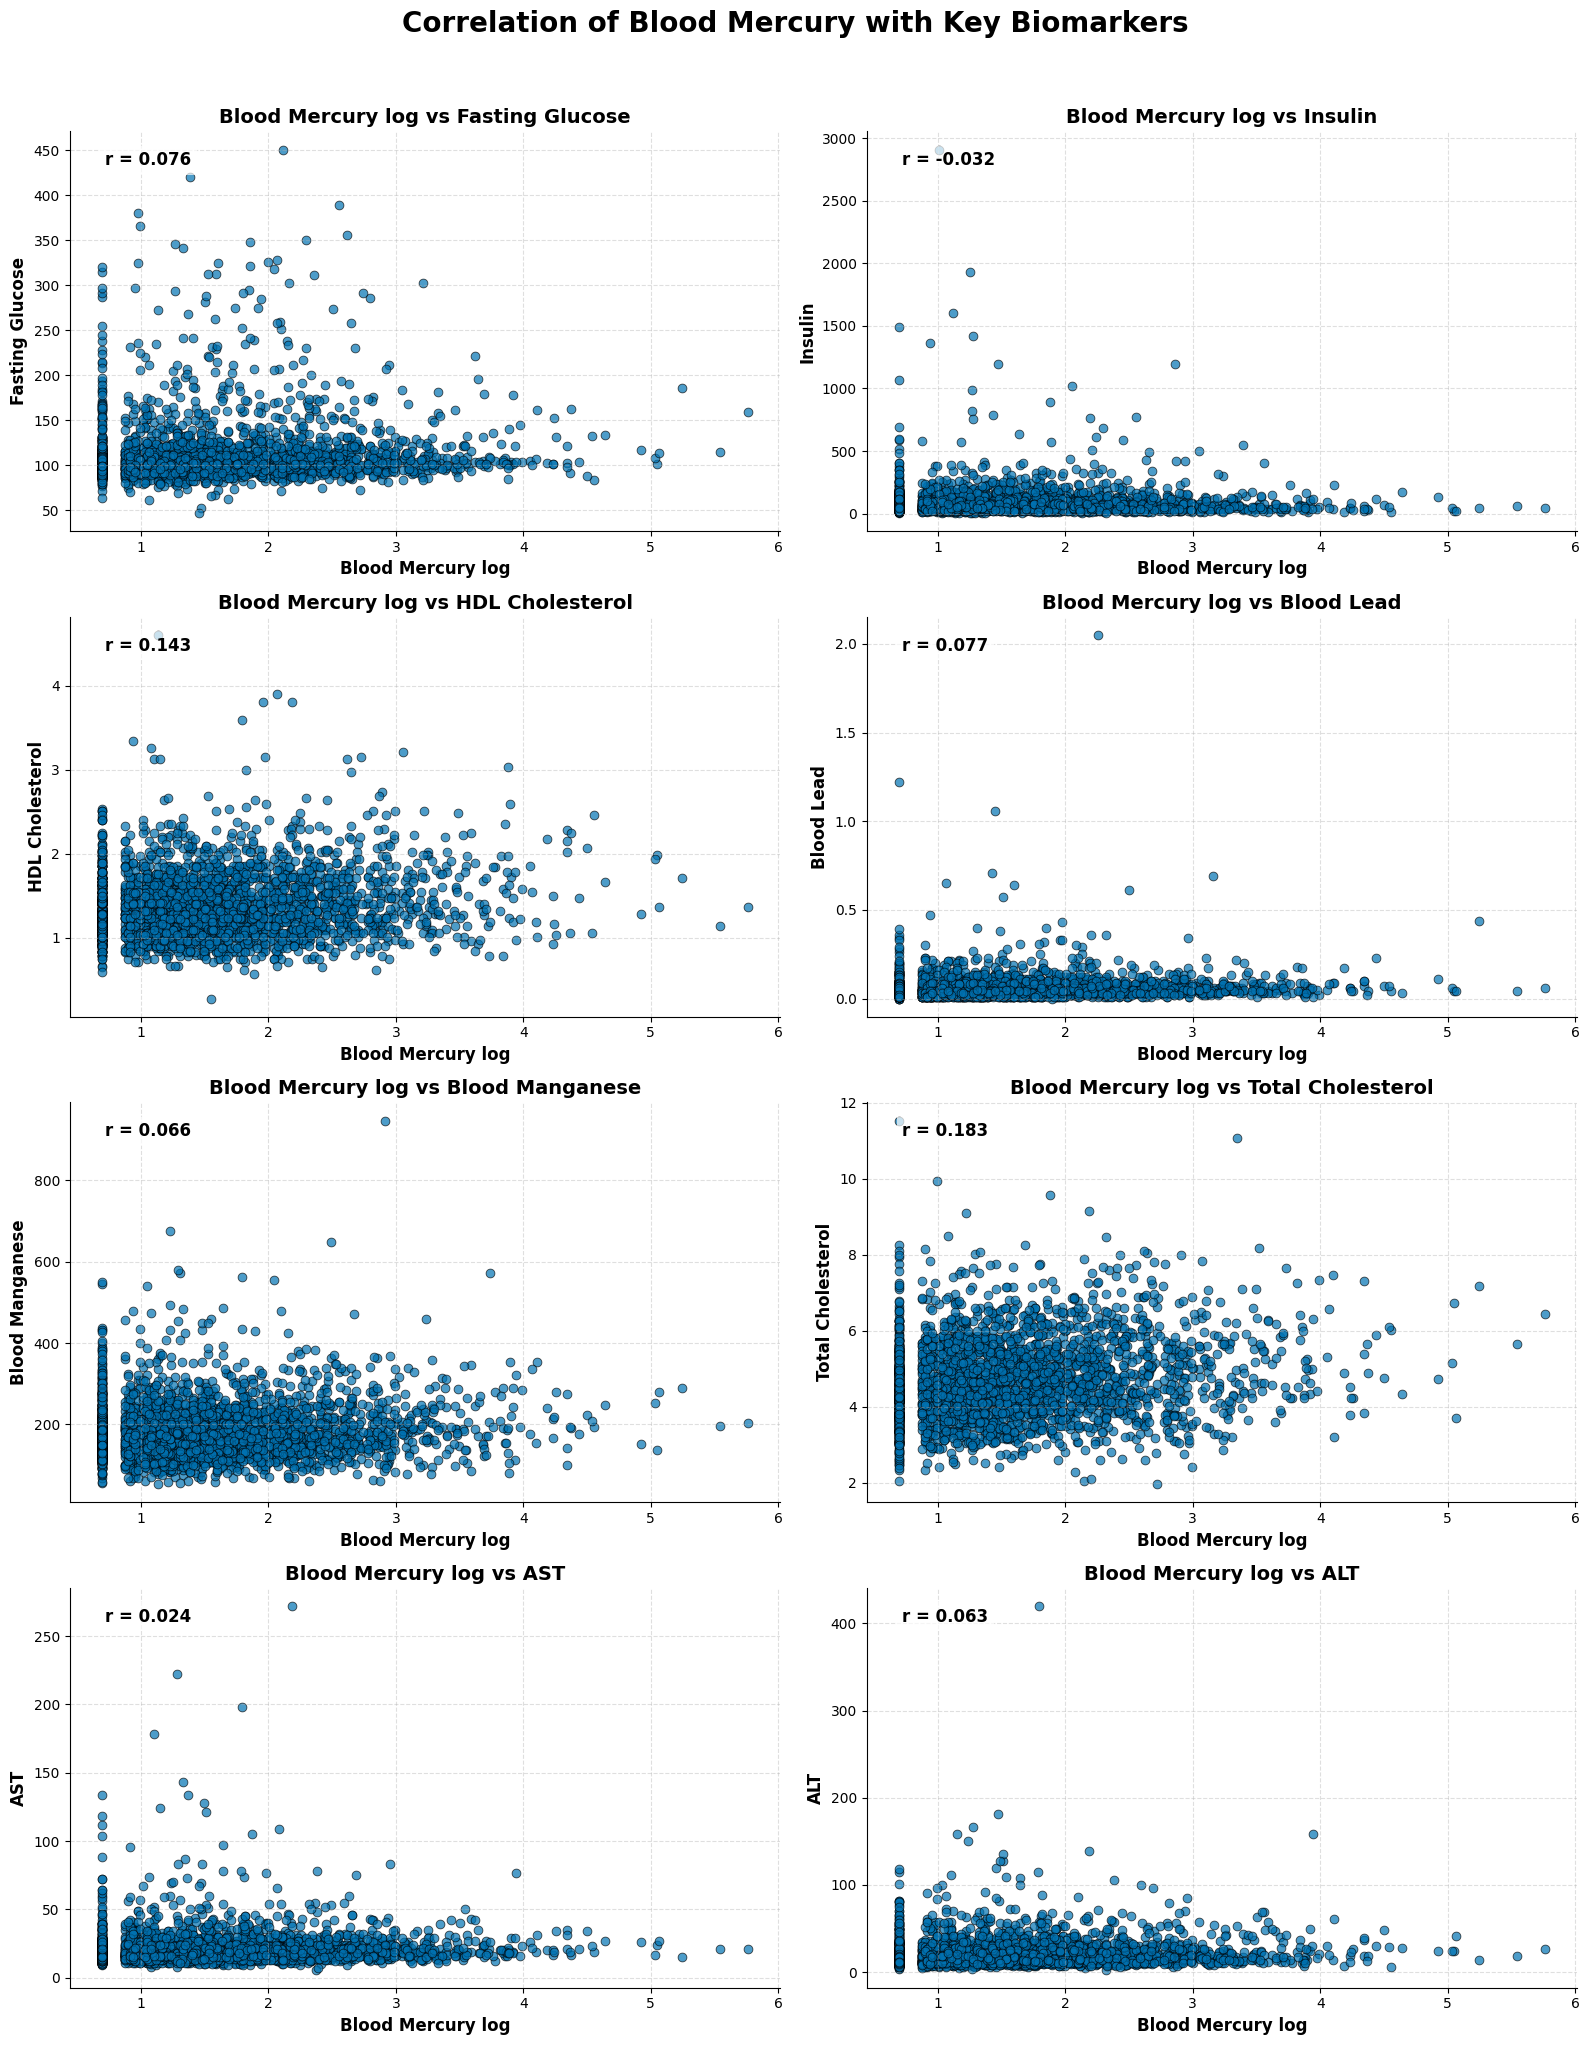

In [31]:
CB_COLOR = "#0072B2"  # Colorblind-safe blue

BASE_COLUMN = "Blood Mercury log"
TARGET_COLUMNS = [
    "Fasting Glucose", "Insulin",
    "HDL Cholesterol", "Blood Lead",
    "Blood Manganese", "Total Cholesterol",
    "AST", "ALT"
]

# Create a 4×2 subplot grid
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
axs = axs.flatten()

for ax, target_col in zip(axs, TARGET_COLUMNS):
    # Compute Pearson correlation
    corr_value = lab[[BASE_COLUMN, target_col]].corr().iloc[0, 1]

    # Scatter plot
    ax.scatter(
        lab[BASE_COLUMN],
        lab[target_col],
        alpha=0.7,
        color=CB_COLOR,
        edgecolors="black",
        linewidth=0.6,
        marker="o",
        s=40
    )

    # Title & labels
    ax.set_title(f"{BASE_COLUMN} vs {target_col}", fontsize=14, fontweight='bold')
    ax.set_xlabel(BASE_COLUMN, fontsize=12, fontweight='bold')
    ax.set_ylabel(target_col, fontsize=12, fontweight='bold')

    # Add correlation text
    ax.text(
        0.05, 0.95,
        f"r = {corr_value:.3f}",
        transform=ax.transAxes,
        fontsize=12,
        fontweight='bold',
        verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
    )

    # Light grid
    ax.grid(True, linestyle="--", alpha=0.4)

    # Remove top and right borders (spines)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# Main title
fig.suptitle(
    "Correlation of Blood Mercury with Key Biomarkers",
    fontsize=20,
    y=1.02,
    fontweight='bold'
)

plt.tight_layout()

# Save figure
plt.savefig(
    "blood_mercury_correlations_4x2.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

### Split the dataset into training and testing subsets to develop and evaluate the regression model

In [23]:
# train test split
from sklearn.model_selection import train_test_split

X = lab.drop(columns=['Blood Mercury log', 'Blood Mercury'])
y = lab['Blood Mercury log']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7
    )

print("X_train set shape:", X_train.shape)
print("X_test set shape:", X_test.shape)
print("y_train set shape:", y_train.shape)
print("y_test set shape:", y_test.shape)


X_train.head()

X_train set shape: (2244, 8)
X_test set shape: (562, 8)
y_train set shape: (2244,)
y_test set shape: (562,)


,Fasting Glucose,Insulin,HDL Cholesterol,Total Cholesterol,Blood Lead,Blood Manganese,AST,ALT
1327,110.0,154.50,1.29,4.47,0.08,130.51,16.0,14.0
7957,126.0,90.96,0.72,3.70,0.04,140.16,19.0,34.0
50,106.0,176.52,1.24,5.28,0.05,111.03,46.0,68.0
8197,99.0,65.70,0.98,5.15,0.03,128.87,25.0,26.0
5590,171.0,133.68,1.29,6.08,0.11,159.63,20.0,22.0


Train and Evaluate the performance of a Linear Regression


In [17]:
# ==================== LINEAR REGRESSION ====================
print("=" * 50)
print("LINEAR REGRESSION EVALUATION")
print("=" * 50)

# Create and train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
lr_y_pred = lr_model.predict(X_test)

# Calculate metrics for Linear Regression
lr_mae = mean_absolute_error(y_test, lr_y_pred)
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_rmse = np.sqrt(lr_mse)
lr_r2 = r2_score(y_test, lr_y_pred)

# Calculate Adjusted R² for Linear Regression
n_lr = len(y_test)
k_lr = X_test.shape[1]
lr_adjusted_r2 = 1 - (1 - lr_r2) * (n_lr - 1) / (n_lr - k_lr - 1)

print(f"MAE: {lr_mae:.4f}")
print(f"MSE: {lr_mse:.4f}")
print(f"RMSE: {lr_rmse:.4f}")
print(f"R² Score: {lr_r2:.4f}")
print(f"Adjusted R²: {lr_adjusted_r2:.4f}")
print(f"Coefficients: {lr_model.coef_}")
print(f"Intercept: {lr_model.intercept_:.4f}")


LINEAR REGRESSION EVALUATION
MAE: 0.6236
MSE: 0.6434
RMSE: 0.8021
R² Score: 0.0632
Adjusted R²: 0.0497
Coefficients: [ 1.69200029e-03 -1.76533142e-04  2.54876171e-01  1.14622127e-01
  6.50793159e-01  7.10628666e-04 -5.72889165e-03  5.71927008e-03]
Intercept: 0.3404


Train and Evaluate the performance of a Random Forest Regressor

In [28]:
# ==================== RANDOM FOREST REGRESSION ====================
print("\n" + "=" * 50)
print("RANDOM FOREST REGRESSION EVALUATION")
print("=" * 50)

# Create and train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_y_pred = rf_model.predict(X_test)

# Calculate metrics for Random Forest
rf_mae = mean_absolute_error(y_test, rf_y_pred)
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_y_pred)

# Calculate Adjusted R² for Random Forest
n_rf = len(y_test)
k_rf = X_test.shape[1]  # Number of features (same as for Linear Regression)
rf_adjusted_r2 = 1 - (1 - rf_r2) * (n_rf - 1) / (n_rf - k_rf - 1)

print(f"MAE: {rf_mae:.4f}")
print(f"MSE: {rf_mse:.4f}")
print(f"RMSE: {rf_rmse:.4f}")
print(f"R² Score: {rf_r2:.4f}")
print(f"Adjusted R²: {rf_adjusted_r2:.4f}")

# ==================== COMPARISON ====================
print("\n" + "=" * 50)
print("MODEL COMPARISON")
print("=" * 50)

print(f"{'Metric':<15} {'Linear Regression':<20} {'Random Forest':<15}")
print("-" * 50)
print(f"{'MAE':<15} {lr_mae:<20.4f} {rf_mae:<15.4f}")
print(f"{'MSE':<15} {lr_mse:<20.4f} {rf_mse:<15.4f}")
print(f"{'RMSE':<15} {lr_rmse:<20.4f} {rf_rmse:<15.4f}")
print(f"{'R²':<15} {lr_r2:<20.4f} {rf_r2:<15.4f}")
print(f"{'Adjusted R²':<15} {lr_adjusted_r2:<20.4f} {rf_adjusted_r2:<15.4f}")


RANDOM FOREST REGRESSION EVALUATION
MAE: 0.6242
MSE: 0.6425
RMSE: 0.8015
R² Score: 0.0645
Adjusted R²: 0.0510

MODEL COMPARISON
Metric          Linear Regression    Random Forest  
--------------------------------------------------
MAE             0.6236               0.6242         
MSE             0.6434               0.6425         
RMSE            0.8021               0.8015         
R²              0.0632               0.0645         
Adjusted R²     0.0497               0.0510         


Residual Analysis and Diagnostic Plots for linear regression

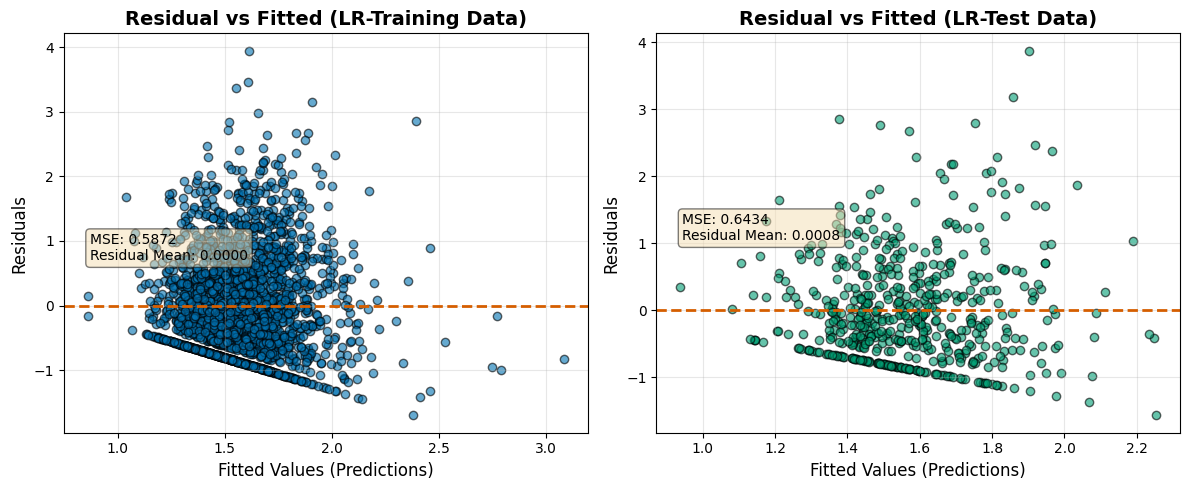

In [26]:
# Generate Predictions and Compute Residuals
# Model predictions
lr_y_pred_train = lr_model.predict(X_train)
lr_y_pred_test = lr_model.predict(X_test)

# Residuals = Actual - Predicted
residuals_train = y_train - lr_y_pred_train
residuals_test = y_test - lr_y_pred_test


# Create Colour-Blind–Friendly Residual vs Fitted Plots
plt.figure(figsize=(12, 5))


#                     TRAINING DATA PLOT
plt.subplot(1, 2, 1)

# Scatterplot of fitted values vs residuals
plt.scatter(
    lr_y_pred_train, residuals_train,
    alpha=0.6,
    color='#0072B2',      # colour-blind safe blue
    edgecolor='black'
)

# Horizontal zero line to assess bias
plt.axhline(
    y=0,
    color='#D55E00',      # colour-blind safe red/orange
    linestyle='--',
    linewidth=2
)

# Axis labels and title
plt.xlabel('Fitted Values (Predictions)', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual vs Fitted (LR-Training Data)',
          fontsize=14, fontweight='bold')

plt.grid(True, alpha=0.3)  # light grid for readability

# Display train MSE and average residual for diagnostics
mse_train = mean_squared_error(y_train, lr_y_pred_train)
plt.text(
    0.05, 0.5,
    f'MSE: {mse_train:.4f}\nResidual Mean: {np.mean(residuals_train):.4f}',
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
)

#                        TEST DATA PLOT
plt.subplot(1, 2, 2)

# Scatterplot for test residuals
plt.scatter(
    lr_y_pred_test, residuals_test,
    alpha=0.6,
    color='#009E73',      # colour-blind safe green
    edgecolor='black'
)

# Zero line again for consistency
plt.axhline(
    y=0,
    color='#D55E00',      # same colour as train plot
    linestyle='--',
    linewidth=2
)

# Axis labels and title
plt.xlabel('Fitted Values (Predictions)', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual vs Fitted (LR-Test Data)',
          fontsize=14, fontweight='bold')

plt.grid(True, alpha=0.3)

# Add test metrics
mse_test = mean_squared_error(y_test, lr_y_pred_test)
plt.text(
    0.05, 0.55,
    f'MSE: {mse_test:.4f}\nResidual Mean: {np.mean(residuals_test):.4f}',
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
)


# ---------------------------------------------------------------
# Final layout adjustments
# ---------------------------------------------------------------
plt.tight_layout()
plt.savefig("linear_reg_residual_vs_fitted_plot..png", dpi=300, bbox_inches='tight')
plt.show()


Residual Analysis and Diagnostic Plots for Random Forest

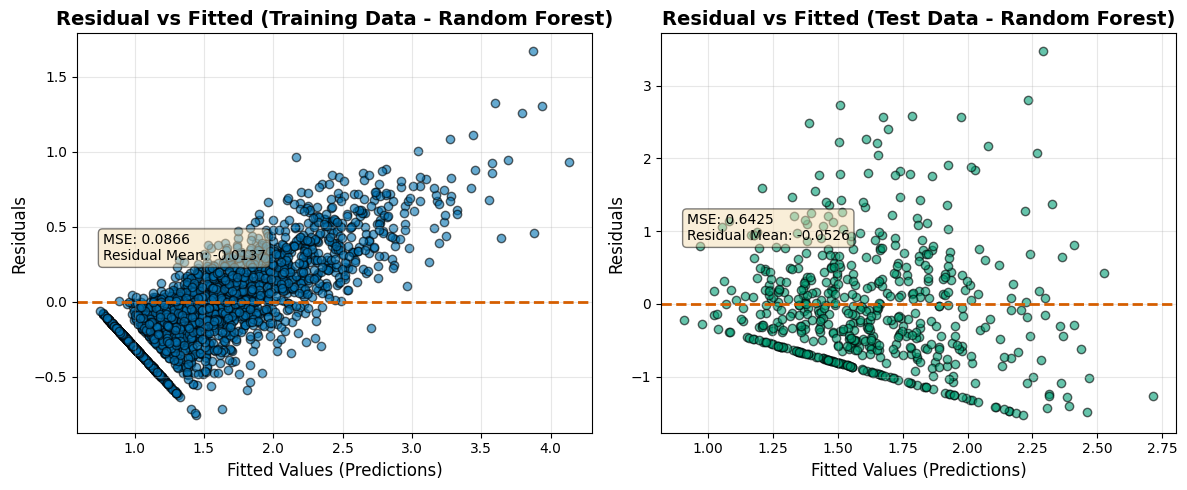

In [29]:
# Generate Predictions and Compute Residuals
# Predictions for training and test sets
rf_y_pred_train = rf_model.predict(X_train)
rf_y_pred_test = rf_model.predict(X_test)

# Residuals = Actual - Predicted
rf_residuals_train = y_train - rf_y_pred_train
rf_residuals_test = y_test - rf_y_pred_test


# Step 3: Create Colour-Blind–Friendly Residual vs Fitted Plots


plt.figure(figsize=(12, 5))  # side-by-side layout


#                     TRAINING DATA PLOT

plt.subplot(1, 2, 1)

# Scatterplot of fitted values vs residuals
plt.scatter(
    rf_y_pred_train,
    rf_residuals_train,
    alpha=0.6,
    color='#0072B2',       # colour-blind safe blue
    edgecolor='black'
)

# Zero reference line (ideal residual mean)
plt.axhline(
    y=0,
    color='#D55E00',       # colour-blind safe orange/red
    linestyle='--',
    linewidth=2
)

# Labels and title
plt.xlabel('Fitted Values (Predictions)', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual vs Fitted (Training Data - Random Forest)',
          fontsize=14, fontweight='bold')

plt.grid(True, alpha=0.3)

# Add training error diagnostics
mse_train = mean_squared_error(y_train, rf_y_pred_train)
plt.text(
    0.05, 0.5,
    f'MSE: {mse_train:.4f}\nResidual Mean: {np.mean(rf_residuals_train):.4f}',
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
)


# ===============================================================
#                         TEST DATA PLOT
# ===============================================================
plt.subplot(1, 2, 2)

# Scatterplot of fitted values vs residuals
plt.scatter(
    rf_y_pred_test,
    rf_residuals_test,
    alpha=0.6,
    color='#009E73',       # colour-blind safe green
    edgecolor='black'
)

# Zero reference line
plt.axhline(
    y=0,
    color='#D55E00',       # same colour for consistency
    linestyle='--',
    linewidth=2
)

# Labels and title
plt.xlabel('Fitted Values (Predictions)', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residual vs Fitted (Test Data - Random Forest)',
          fontsize=14, fontweight='bold')

plt.grid(True, alpha=0.3)

# Add test error diagnostics
mse_test = mean_squared_error(y_test, rf_y_pred_test)
plt.text(
    0.05, 0.55,
    f'MSE: {mse_test:.4f}\nResidual Mean: {np.mean(rf_residuals_test):.4f}',
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
)


# ---------------------------------------------------------------
# Final layout adjustment
# ---------------------------------------------------------------
plt.tight_layout()
plt.savefig("random_forest_residual_vs_fitted_plot..png", dpi=300, bbox_inches='tight')
plt.show()
